<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Box Plots**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab you will perform the following:


-   Visualize the distribution of data.

-   Visualize the relationship between two features.

-   Visualize data composition and comparisons using box plots.


### Setup: Connecting to the Database


#### 1. Download the Database File


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('survey-data.sqlite')

In [2]:
import urllib.request

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite"
filename = "survey-data.sqlite"
urllib.request.urlretrieve(url, filename)

('survey-data.sqlite', <http.client.HTTPMessage at 0x2d49e8e4a50>)

#### 2. Connect to the Database


**Install the needed libraries**


In [3]:
!pip install pandas


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('survey-results-public.sqlite')


## Demo: Basic SQL Queries


#### Demo 1: Count the Number of Rows in the Table


In [6]:
import sqlite3
import pandas as pd

# Connect to the correct database file
conn = sqlite3.connect('survey-data.sqlite')

# Count the number of rows in the main table
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)

   COUNT(*)
0     65437


In [7]:
# Show the first 5 rows of the main table
df_preview = pd.read_sql_query("SELECT * FROM main LIMIT 5", conn)
print(df_preview)

   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time       None  Apples   
4   Student, full-time       None  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                               None   
4                                 

#### Demo 2: List All Tables


In [8]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


#### Demo 3: Group Data by Age


In [9]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Visualizing Data


### Task 1: Visualizing the Distribution of Data


**1. Box Plot of `CompTotal` (Total Compensation)**


Use a box plot to analyze the distribution and outliers in total compensation.


Q1 (25th percentile): 54.00k
Median (50th percentile): 95.00k
Q3 (75th percentile): 173.00k


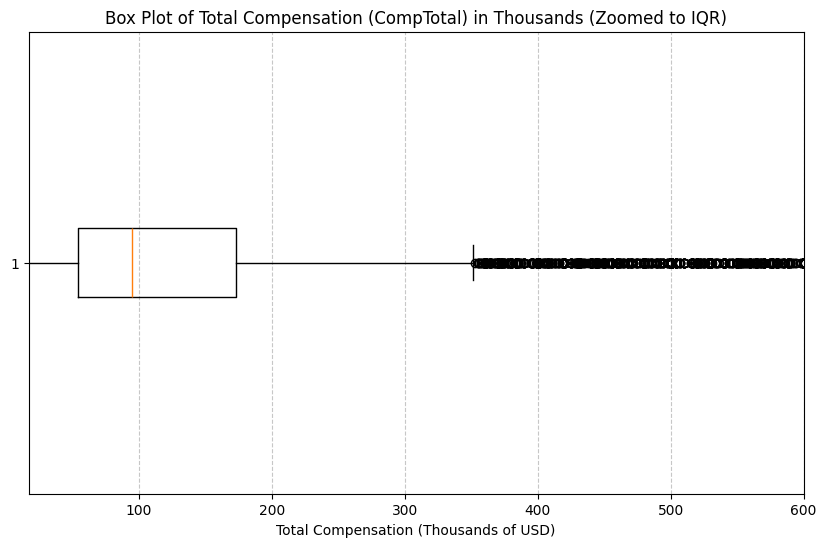

In [12]:
import numpy as np
import pandas as pd

# Load compensation data from the database
df_comp = pd.read_sql_query("SELECT CompTotal FROM main", conn)

# Drop missing or invalid values and filter for reasonable compensation
df_comp = df_comp.dropna()
df_comp = df_comp[(df_comp['CompTotal'] > 0) & (df_comp['CompTotal'] < 1_000_000)]

# Convert compensation to thousands
df_comp['CompTotalK'] = df_comp['CompTotal'] / 1000

# Calculate percentiles for zooming
q5, q95 = np.percentile(df_comp['CompTotalK'], [5, 95])
q25, q50, q75 = np.percentile(df_comp['CompTotalK'], [25, 50, 75])

print(f"Q1 (25th percentile): {q25:.2f}k")
print(f"Median (50th percentile): {q50:.2f}k")
print(f"Q3 (75th percentile): {q75:.2f}k")

plt.figure(figsize=(10, 6))
plt.boxplot(df_comp['CompTotalK'], vert=False)
plt.xlim(q5, q95)  # Zoom in on the central range
plt.title('Box Plot of Total Compensation (CompTotal) in Thousands (Zoomed to IQR)')
plt.xlabel('Total Compensation (Thousands of USD)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

**2. Box Plot of Age (converted to numeric values)**


Convert the `Age` column into numerical values and visualize the distribution.


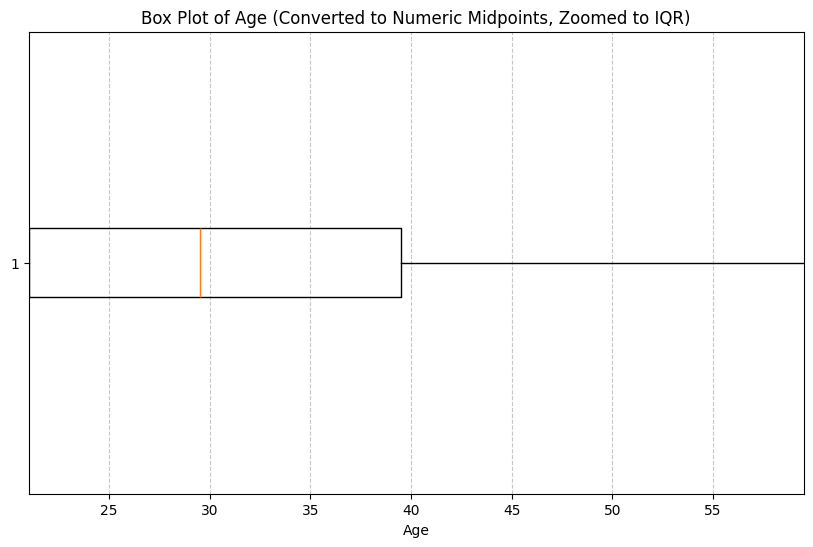

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Load Age column from the main table
df_age = pd.read_sql_query("SELECT Age FROM main", conn)

# Convert Age column to numeric midpoints
def age_to_midpoint(age_str):
    if pd.isna(age_str):
        return None
    if '-' in age_str:
        parts = age_str.split('-')
        return (int(parts[0]) + int(parts[1].split()[0])) / 2
    elif 'under' in age_str.lower():
        return 18
    elif 'older' in age_str.lower():
        return 65
    else:
        return None

age_numeric = df_age['Age'].apply(age_to_midpoint)

# Drop missing values and filter for reasonable ages
age_numeric = age_numeric.dropna()
age_numeric = age_numeric[(age_numeric > 10) & (age_numeric < 100)]

# Calculate percentiles for zooming
q5, q95 = np.percentile(age_numeric, [5, 95])

plt.figure(figsize=(10, 6))
plt.boxplot(age_numeric, vert=False)
plt.xlim(q5, q95)  # Focus on the central range
plt.title('Box Plot of Age (Converted to Numeric Midpoints, Zoomed to IQR)')
plt.xlabel('Age')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

### Task 2: Visualizing Relationships in Data


**1. Box Plot of `CompTotal` Grouped by Age Groups:**


Visualize the distribution of compensation across different age groups.


C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\221281014.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=age_labels, showfliers=False)


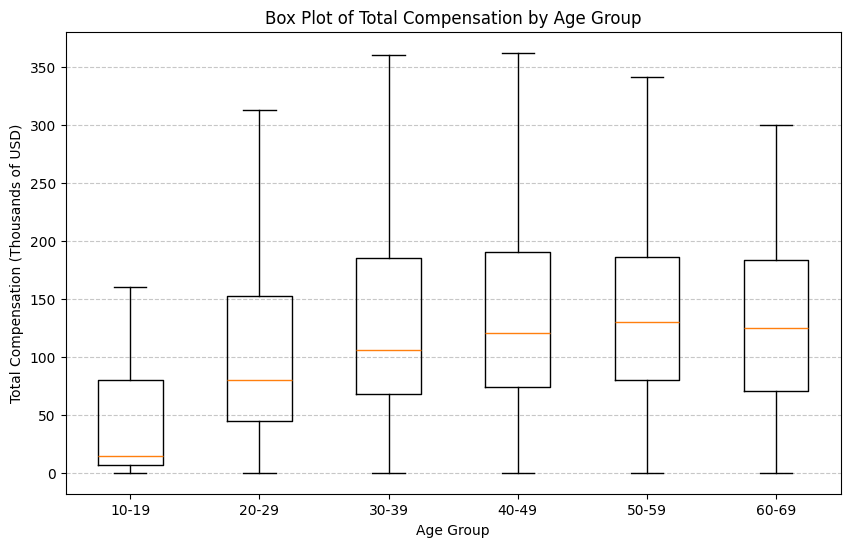

In [15]:
# your code goes here
#Box Plot of `CompTotal` Grouped by Age Groups:**
#Visualize the distribution of compensation across different age groups.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load compensation and age data from the database
df = pd.read_sql_query("SELECT CompTotal, Age FROM main", conn)

# Clean data: drop missing or invalid values
df = df.dropna()
df = df[(df['CompTotal'] > 0) & (df['CompTotal'] < 1_000_000)]

# Convert Age to numeric midpoints
def age_to_midpoint(age_str):
    if pd.isna(age_str):
        return None
    if '-' in age_str:
        parts = age_str.split('-')
        return (int(parts[0]) + int(parts[1].split()[0])) / 2
    elif 'under' in age_str.lower():
        return 18
    elif 'older' in age_str.lower():
        return 65
    else:
        return None

df['AgeNumeric'] = df['Age'].apply(age_to_midpoint)
df = df.dropna(subset=['AgeNumeric'])

# Bin ages into groups (e.g., 10-year bins)
age_bins = [10, 20, 30, 40, 50, 60, 70]
age_labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69']
df['AgeGroup'] = pd.cut(df['AgeNumeric'], bins=age_bins, labels=age_labels, right=False)

# Convert compensation to thousands for readability
df['CompTotalK'] = df['CompTotal'] / 1000

# Prepare data for boxplot
boxplot_data = [df[df['AgeGroup'] == group]['CompTotalK'] for group in age_labels]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=age_labels, showfliers=False)
plt.title('Box Plot of Total Compensation by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Compensation (Thousands of USD)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**2. Box Plot of `CompTotal` Grouped by Job Satisfaction (`JobSatPoints_6`):**


Examine how compensation varies based on job satisfaction levels.


C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\2142187350.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['JobSatNum'] = df_top['JobSat'].map(level_map)
C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\2142187350.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=range(1, len(top_levels)+1), patch_artist=True, showfliers=False)


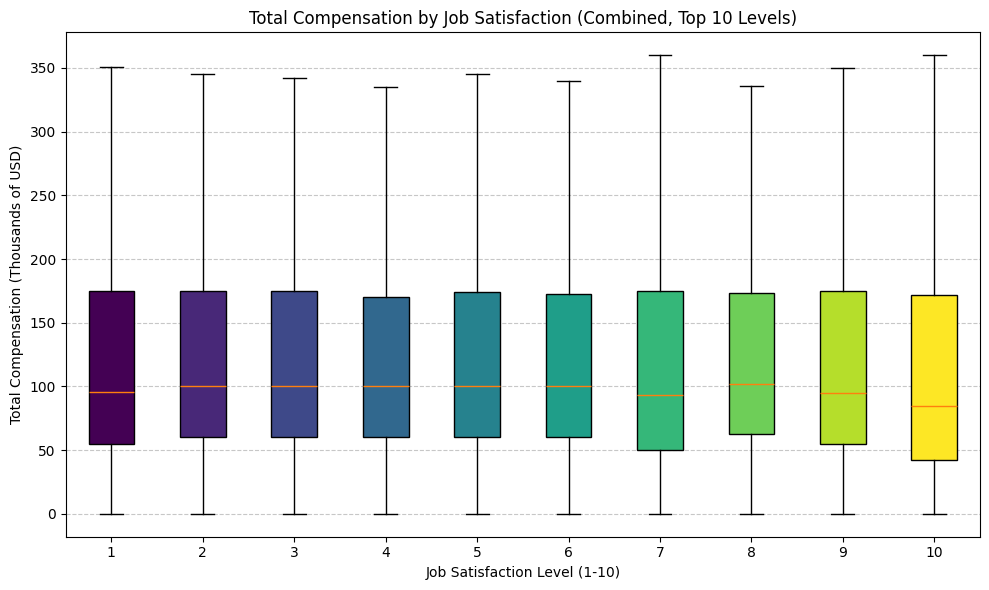

Job Satisfaction Level Mapping:
1: 0.0
2: 10.0
3: 20.0
4: 5.0
5: 30.0
6: 15.0
7: 50.0
8: 25.0
9: 40.0
10: 100.0


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Find all JobSatPoints columns
query = "PRAGMA table_info(main)"
columns = pd.read_sql_query(query, conn)['name'].tolist()
job_sat_cols = [col for col in columns if col.startswith('JobSatPoints')]

# Combine all JobSatPoints columns into one DataFrame
dfs = []
for col in job_sat_cols:
    temp = pd.read_sql_query(f"SELECT CompTotal, [{col}] as JobSat, '{col}' as Source FROM main", conn)
    dfs.append(temp)
df_all = pd.concat(dfs, ignore_index=True)

# Clean data
df_all = df_all.dropna()
df_all = df_all[(df_all['CompTotal'] > 0) & (df_all['CompTotal'] < 1_000_000)]

# Get the top 10 most common JobSat values
top_levels = df_all['JobSat'].value_counts().nlargest(10).index.tolist()
df_top = df_all[df_all['JobSat'].isin(top_levels)]

# Assign numeric x-axis values
level_map = {level: i+1 for i, level in enumerate(top_levels)}
df_top['JobSatNum'] = df_top['JobSat'].map(level_map)

# Prepare data for boxplot
boxplot_data = [df_top[df_top['JobSatNum'] == i]['CompTotal'] / 1000 for i in range(1, len(top_levels)+1)]

plt.figure(figsize=(10, 6))
box = plt.boxplot(boxplot_data, labels=range(1, len(top_levels)+1), patch_artist=True, showfliers=False)

# Add color to boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(top_levels)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Total Compensation by Job Satisfaction (Combined, Top 10 Levels)')
plt.xlabel('Job Satisfaction Level (1-10)')
plt.ylabel('Total Compensation (Thousands of USD)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Show mapping for reference
print("Job Satisfaction Level Mapping:")
for i, level in enumerate(top_levels, 1):
    print(f"{i}: {level}")

### Task 3: Visualizing the Composition of Data


**1. Box Plot of `ConvertedCompYearly` for the Top 5 Developer Types:**


Analyze compensation across the top 5 developer roles.


C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\2591418567.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=top_roles, patch_artist=True, showfliers=False)


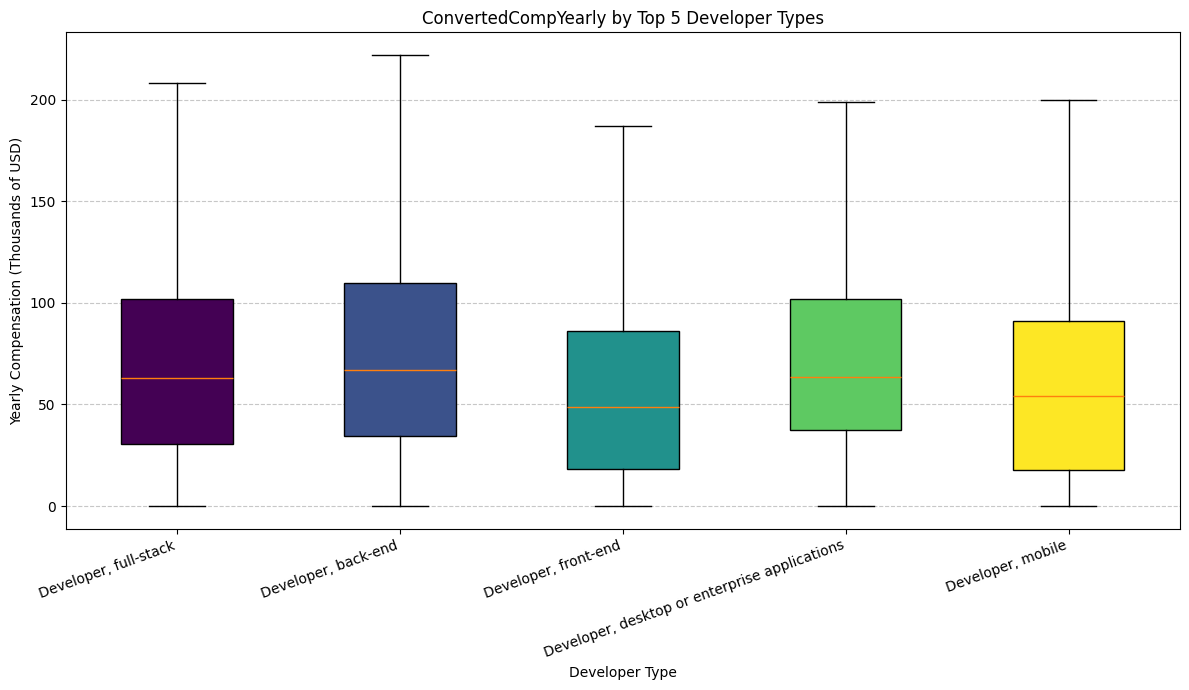

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Load compensation and developer type data from the database
df = pd.read_sql_query("SELECT ConvertedCompYearly, DevType FROM main", conn)

# Drop missing or invalid values
df = df.dropna()
df = df[(df['ConvertedCompYearly'] > 0) & (df['ConvertedCompYearly'] < 1_000_000)]

# Split DevType into individual roles (since it's often a semicolon-separated list)
df_roles = df.assign(DevType=df['DevType'].str.split(';')).explode('DevType')
df_roles['DevType'] = df_roles['DevType'].str.strip()

# Get the top 5 most common developer roles
top_roles = df_roles['DevType'].value_counts().nlargest(5).index.tolist()
df_top = df_roles[df_roles['DevType'].isin(top_roles)]

# Prepare data for boxplot
boxplot_data = [df_top[df_top['DevType'] == role]['ConvertedCompYearly'] / 1000 for role in top_roles]

plt.figure(figsize=(12, 7))
box = plt.boxplot(boxplot_data, labels=top_roles, patch_artist=True, showfliers=False)

# Add color to boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(top_roles)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('ConvertedCompYearly by Top 5 Developer Types')
plt.xlabel('Developer Type')
plt.ylabel('Yearly Compensation (Thousands of USD)')
plt.xticks(rotation=20, ha='right')
plt.grid(True   , axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

**2. Box Plot of `CompTotal` for the Top 5 Countries:**


Analyze compensation across respondents from the top 5 countries.


C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\797504529.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=top_countries, patch_artist=True, showfliers=False)


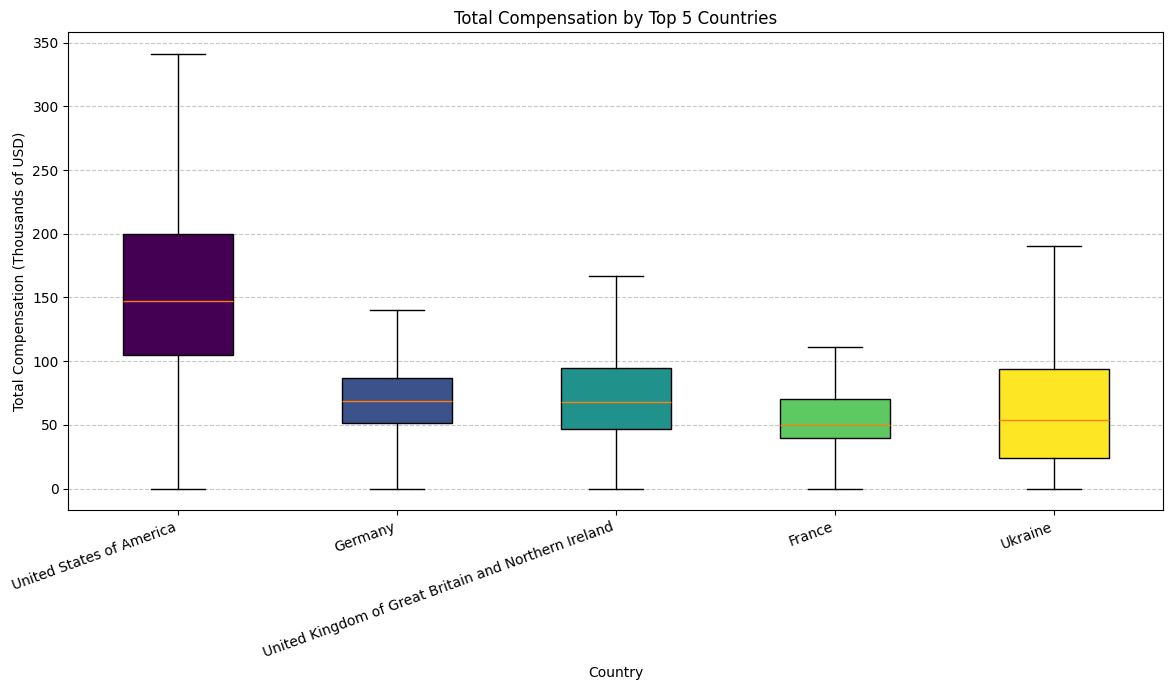

In [23]:
# your code goes here
import matplotlib.pyplot as plt
import pandas as pd

# Load compensation and country data from the database
df = pd.read_sql_query("SELECT CompTotal, Country FROM main", conn)

# Drop missing or invalid values
df = df.dropna()
df = df[(df['CompTotal'] > 0) & (df['CompTotal'] < 1_000_000)]

# Get the top 5 most common countries
top_countries = df['Country'].value_counts().nlargest(5).index.tolist()
df_top = df[df['Country'].isin(top_countries)]

# Prepare data for boxplot
boxplot_data = [df_top[df_top['Country'] == country]['CompTotal'] / 1000 for country in top_countries]

plt.figure(figsize=(12, 7))
box = plt.boxplot(boxplot_data, labels=top_countries, patch_artist=True, showfliers=False)

# Add color to boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(top_countries)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Total Compensation by Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Total Compensation (Thousands of USD)')
plt.xticks(rotation=20, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Task 4: Visualizing Comparison of Data


**1. Box Plot of CompTotal Across Employment Types:**


Analyze compensation for different employment types.


C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\2945702061.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=top_employment, patch_artist=True, showfliers=False)


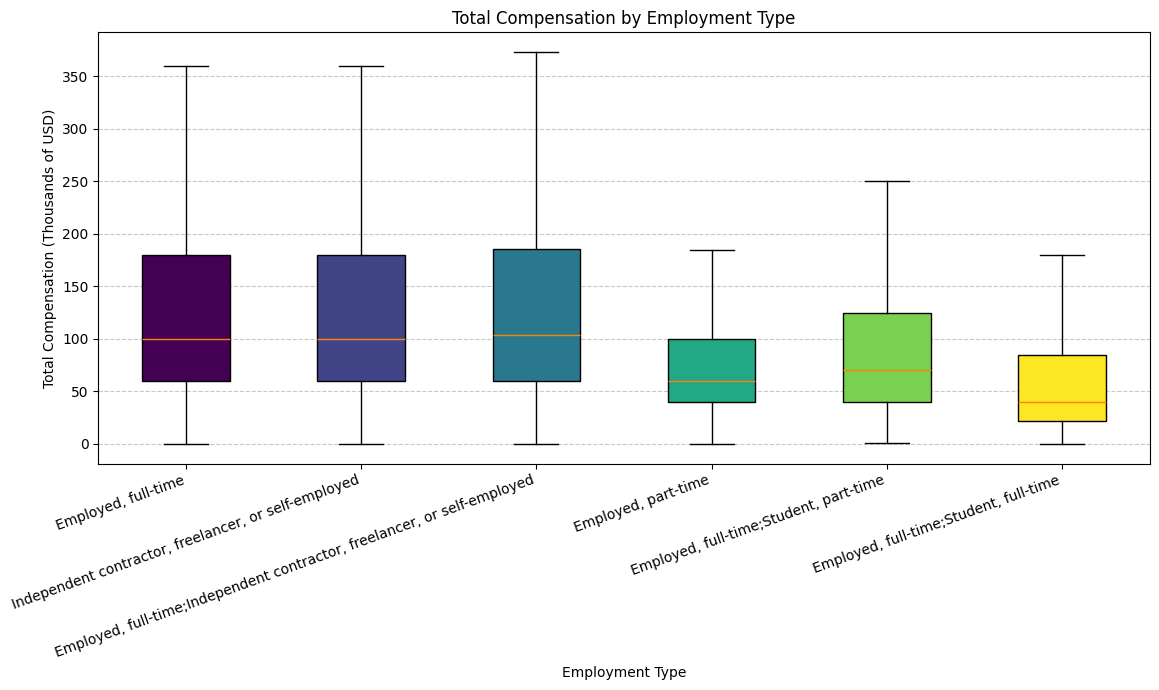

In [25]:
# your code goes here
import matplotlib.pyplot as plt
import pandas as pd

# Load compensation and employment type data from the database
df = pd.read_sql_query("SELECT CompTotal, Employment FROM main", conn)

# Drop missing or invalid values
df = df.dropna()
df = df[(df['CompTotal'] > 0) & (df['CompTotal'] < 1_000_000)]

# Get the top 6 most common employment types for clarity
top_employment = df['Employment'].value_counts().nlargest(6).index.tolist()
df_top = df[df['Employment'].isin(top_employment)]

# Prepare data for boxplot
boxplot_data = [df_top[df_top['Employment'] == emp]['CompTotal'] / 1000 for emp in top_employment]

plt.figure(figsize=(12, 7))
box = plt.boxplot(boxplot_data, labels=top_employment, patch_artist=True, showfliers=False)

# Add color to boxes
colors = plt.cm.viridis(np.linspace(0, 1, len(top_employment)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Total Compensation by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Total Compensation (Thousands of USD)')
plt.xticks(rotation=20, ha='right')
plt.grid(True, axis='y', linestyle= '--', alpha=0.7)
plt.tight_layout()
plt.show()

**2. Box Plot of `YearsCodePro` by Job Satisfaction (`JobSatPoints_6`):**


Examine the distribution of professional coding years by job satisfaction levels.


C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\2266539615.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['JobSatNum'] = df_top['JobSatPoints_6'].map(level_map)
C:\Users\Big Honk\AppData\Local\Temp\ipykernel_18884\2266539615.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=range(1, len(top_levels)+1), patch_artist=True, showfliers=False)


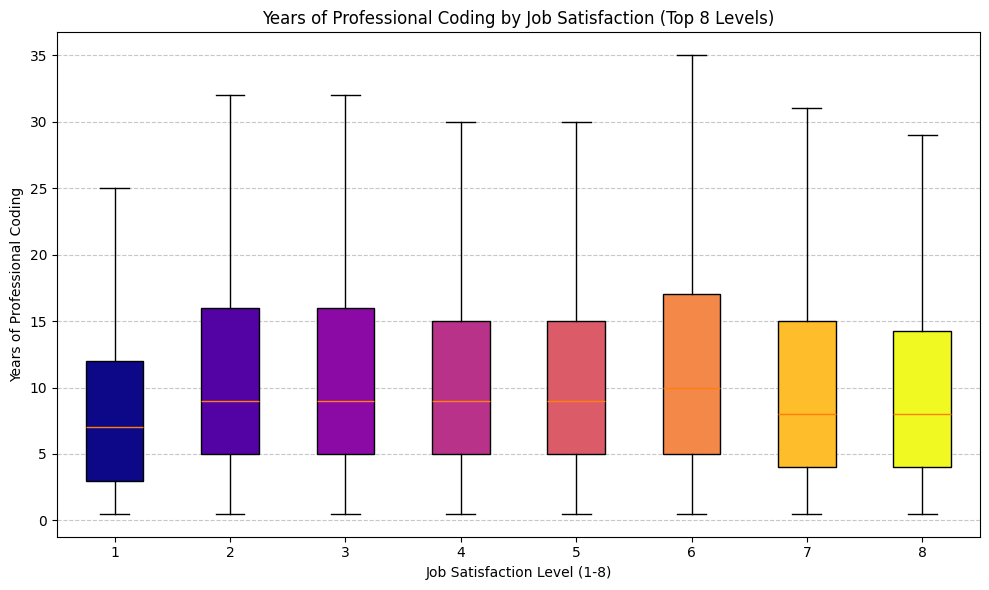

Job Satisfaction Level Mapping:
1: 0.0
2: 20.0
3: 10.0
4: 30.0
5: 15.0
6: 25.0
7: 50.0
8: 40.0


In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load YearsCodePro and JobSatPoints_6 from the database
df = pd.read_sql_query("SELECT YearsCodePro, JobSatPoints_6 FROM main", conn)

# Convert YearsCodePro to numeric (handle 'Less than 1 year', 'More than 50 years', etc.)
def to_numeric_years(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        val = val.strip()
        if val.lower().startswith('less'):
            return 0.5
        if val.lower().startswith('more'):
            return 51
        try:
            return float(val)
        except:
            return np.nan
    return val

df['YearsCodeProNum'] = df['YearsCodePro'].apply(to_numeric_years)

# Drop missing or invalid values
df = df.dropna(subset=['YearsCodeProNum', 'JobSatPoints_6'])

# Get the top 8 most common JobSatPoints_6 values
top_levels = df['JobSatPoints_6'].value_counts().nlargest(8).index.tolist()
df_top = df[df['JobSatPoints_6'].isin(top_levels)]

# Assign numeric x-axis values
level_map = {level: i+1 for i, level in enumerate(top_levels)}
df_top['JobSatNum'] = df_top['JobSatPoints_6'].map(level_map)

# Prepare data for boxplot
boxplot_data = [df_top[df_top['JobSatNum'] == i]['YearsCodeProNum'] for i in range(1, len(top_levels)+1)]

plt.figure(figsize=(10, 6))
box = plt.boxplot(boxplot_data, labels=range(1, len(top_levels)+1), patch_artist=True, showfliers=False)

# Add color to boxes
colors = plt.cm.plasma(np.linspace(0, 1, len(top_levels)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Years of Professional Coding by Job Satisfaction (Top 8 Levels)')
plt.xlabel('Job Satisfaction Level (1-8)')
plt.ylabel('Years of Professional Coding')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Show mapping for reference
print("Job Satisfaction Level Mapping:")
for i, level in enumerate(top_levels, 1):
    print(f"{i}: {level}")

### Final Step: Close the Database Connection


After completing the lab, close the connection to the SQLite database:


In [29]:
conn.close()

## Summary


In this lab, you used box plots to visualize various aspects of the dataset, focusing on:

- Visualize distributions of compensation and age.

- Explore relationships between compensation, job satisfaction, and professional coding experience.

- Analyze data composition across developer roles and countries.

- Compare compensation across employment types and satisfaction levels.

Box plots provided clear insights into the spread, outliers, and central tendencies of various features in the dataset.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|               
|2024-10-07|1.2|Madhusudan Moole|Reviewed and updated lab|                                                                                      
|2024-10-06|1.0|Raghul Ramesh|Created lab|-->


Copyright © IBM Corporation. All rights reserved.
